In [1]:
%matplotlib inline
import numpy as np
import scipy 
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import interpolate



In [10]:
# general properties
g = 9.81 # [m/s²] in positive x direction

# particle properties
d_p = 0.0002 # [m]
rho_s = 2500.0 # [kg/m³]
k_s = [11.9238701002, 1.19238701002, 0.119238701002] # [W/m·K]
c_s = 1000 # [J/kg·K]
A_p = np.pi * d_p ** 2.0 / 4.0 # [m²]
A = np.pi * d_p ** 2.0 # [m²]
V_p = 4.0 / 3.0 * np.pi * (d_p / 2.0) ** 3.0 # [m³]
T_p_0 = 500.0 # [K]
mass = rho_s * V_p # [kg]
print(mass)
R = d_p/2.0


# fluid material properties
rho_f = 1000.0 # [kg/m³]
mu_f = 0.001 # [Pa·s]
k_f = 0.5 # [W/m·K]
c_f = 5000.0 # [J/kg·K]
T_f = 300.0 # [K]
Pr = c_f * mu_f / k_f

print(Pr)


#injection properties
len_inj = 0.0002 # [m]
wid_inj = 0.0002 # [m]
time_inj = 0.0001 # [s]
mass_flow_inj = mass/time_inj # [kg/s]
print(mass_flow_inj*1000*60*60, "g/h" )
mass_flow_ton = mass_flow_inj*60*60/1000 #[ton/h]
print(mass_flow_ton, "t/h")

1.0471975511965978e-08
10.0
376.9911184307752 g/h
0.0003769911184307752 t/h


In [3]:
# helper functions

def SchillerNaumann1933(Re):
    # calculates CD using SchillerNaumann
    part1 = (24.0/(Re+0.00000001)) * (1 + 0.15 * Re**(0.687))
    part2 = 0.44
    cd = max(part1,part2)
    return cd

def Stokes(Re):
    # calculates CD using Stokes
    cd = 24.0/(Re+0.00000000001)
    return cd

def NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p):
    # Calculate terminal velocity estimated for a newtonian drag regime
    vel = 2.46 * (((rho_s - rho_f) * g * d_p/2.0 / rho_f)**0.5)
    #vel = (4.0/6)*((rho_s - rho_f) * g * d_p / rho_f * 0.44) 
    return vel

def StokesTerminalVelocity(rho_s, rho_f, g, d_p, mu_f):
    velStokes = (1.0/18)* ( rho_s - rho_f)* g *d_p*d_p/mu_f
    return velStokes

def residual(v_inf):
    Re = rho_f * v_inf * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
    
    delta_v = 0.5 * rho_f * A_p * C_D * v_inf * v_inf - (rho_s - rho_f) * V_p * g
    
    return delta_v

def Reynolds(rho, mu, L, U):
    Re = rho * U * L / mu
    return Re

def transient_velocity( vel, time, regime ):
    # Function to calculate velocity against time (to be numerically integrated)
    C1 = (g/rho_s)*(rho_s - rho_f)
    Re = rho_f * vel * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
        
    C2 = (0.5 * rho_f * A_p * C_D / (V_p * rho_s)) 
    return C1 - C2* vel* vel

def find_x_interpolate_given_f(interface, x, t):
    y_array = np.array(x)
    yreduced = y_array - interface
    freduced = interpolate.UnivariateSpline(t, yreduced, s=0)
    time_colision = freduced.roots()
    
    return time_colision

def find_f_interpolate_given_x(x_array, y_array, time):
    f = interpolate.interp1d(x_array, y_array)
    ynew = f(time)
    
    return ynew

def RanzMarshall(Re, Pr):
    Nu = 2.0 + 0.6 * Re ** 0.5 * Pr ** 0.333333333
    return Nu

def Whitaker(Re, Pr, mu_ratio = 1.0):
    Nu = 2.0 + (0.4 * Re ** 0.5 + 0.06 * Re ** 0.6666666666666667) * Pr ** 0.4 * mu_ratio ** 0.25
    return Nu;



In [4]:
# loading the digitized data

rocky_data_one_way_padrao = open("falling_particle_padrao_RM_one_way.csv", 'r')
t_one_way_padrao, temp_one_way_padrao, particlez_one_way_padrao, velocity_one_way_padrao = \
np.loadtxt(rocky_data_one_way_padrao, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_padrao.close()

rocky_data_two_way_padrao = open("falling_particle_padrao_RM_two_way.csv", 'r')
t_two_way_padrao, temp_two_way_padrao, particlez_two_way_padrao, velocity_two_way_padrao = \
np.loadtxt(rocky_data_two_way_padrao, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_two_way_padrao.close()

rocky_data_one_way_improved_Bi_01 = open("falling_particle_padrao_RM_one_way_Bi-01.csv", 'r')
t_one_way_improved_Bi_01, temp_one_way_improved_Bi_01, particlez_one_way_improved_Bi_01, velocity_one_way_improved_Bi_01 = \
np.loadtxt(rocky_data_one_way_improved_Bi_01, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_01.close()

rocky_data_one_way_improved_Bi_1 = open("falling_particle_padrao_RM_one_way_Bi-1.csv", 'r')
t_one_way_improved_Bi_1, temp_one_way_improved_Bi_1, particlez_one_way_improved_Bi_1, velocity_one_way_improved_Bi_1 = \
np.loadtxt(rocky_data_one_way_improved_Bi_1, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_1.close()

rocky_data_one_way_improved_Bi_10 = open("falling_particle_padrao_RM_one_way_Bi-10.csv", 'r')
t_one_way_improved_Bi_10, temp_one_way_improved_Bi_10, particlez_one_way_improved_Bi_10, velocity_one_way_improved_Bi_10 = \
np.loadtxt(rocky_data_one_way_improved_Bi_10, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way_improved_Bi_10.close()

rocky_data_two_way_improved_Bi_01 = open("falling_particle_padrao_RM_two_way_Bi-01.csv", 'r')
t_two_way_improved_Bi_01, temp_two_way_improved_Bi_01, particlez_two_way_improved_Bi_01, velocity_two_way_improved_Bi_01 = \
np.loadtxt(rocky_data_two_way_improved_Bi_01, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_two_way_improved_Bi_01.close()

rocky_data_two_way_improved_Bi_1 = open("falling_particle_padrao_RM_two_way_Bi-1.csv", 'r')
t_two_way_improved_Bi_1, temp_two_way_improved_Bi_1, particlez_two_way_improved_Bi_1, velocity_two_way_improved_Bi_1 = \
np.loadtxt(rocky_data_two_way_improved_Bi_1, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_two_way_improved_Bi_1.close()

rocky_data_two_way_improved_Bi_10 = open("falling_particle_padrao_RM_two_way_Bi-10.csv", 'r')
t_two_way_improved_Bi_10, temp_two_way_improved_Bi_10, particlez_two_way_improved_Bi_10, velocity_two_way_improved_Bi_10 = \
np.loadtxt(rocky_data_two_way_improved_Bi_10, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_two_way_improved_Bi_10.close()


In [14]:
regime = 1
print("Terminal velocity using Newtonian =", NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p),  "[m/s] ")

print("\n Terminal velocity calculations: \n")
v_inf = fsolve(residual, 0.1)[0]

print("Particle terminal velocity =", v_inf, "[m/s] ")


#integrating to get velocity
#vel_water_one_way_RM = scipy.integrate.odeint(transient_velocity, velocity_one_way_RM[0], t_one_way_RM, (regime,)).reshape((t_one_way_RM.size))
vel_one_way_padrao = scipy.integrate.odeint(transient_velocity, velocity_one_way_padrao[0], t_one_way_padrao, (regime,)).reshape((temp_one_way_padrao.size))
vel_one_way_improved_bi01 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_Bi_01[0], t_one_way_improved_Bi_01, (regime,)).reshape((t_one_way_improved_Bi_01.size))
vel_one_way_improved_bi1 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_Bi_1[0], t_one_way_improved_Bi_1, (regime,)).reshape((t_one_way_improved_Bi_1.size))
vel_one_way_improved_bi10 = scipy.integrate.odeint(transient_velocity, velocity_one_way_improved_Bi_10[0], t_one_way_improved_Bi_10, (regime,)).reshape((t_one_way_improved_Bi_10.size))
#two_way
vel_two_way_padrao = scipy.integrate.odeint(transient_velocity, velocity_two_way_padrao[0], t_two_way_padrao, (regime,)).reshape((t_two_way_padrao.size))
vel_two_way_improved_bi01 = scipy.integrate.odeint(transient_velocity, velocity_two_way_improved_Bi_01[0], t_two_way_improved_Bi_01, (regime,)).reshape((t_two_way_improved_Bi_01.size))
vel_two_way_improved_bi1 = scipy.integrate.odeint(transient_velocity, velocity_two_way_improved_Bi_1[0], t_two_way_improved_Bi_1, (regime,)).reshape((t_two_way_improved_Bi_1.size))
vel_two_way_improved_bi10 = scipy.integrate.odeint(transient_velocity, velocity_two_way_improved_Bi_10[0], t_two_way_improved_Bi_10, (regime,)).reshape((t_two_way_improved_Bi_10.size))


Reynolds_one_way = Reynolds(rho_f, mu_f, d_p, vel_one_way_padrao)
Reynolds_one_way_improved_Bi_01 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_bi01)
Reynolds_one_way_improved_Bi_1 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_bi1)
Reynolds_one_way_improved_Bi_10 = Reynolds(rho_f, mu_f, d_p, vel_one_way_improved_bi10)
Reynolds_two_way = Reynolds(rho_f, mu_f, d_p, vel_two_way_padrao)
Reynolds_two_way_improved_Bi_01 = Reynolds(rho_f, mu_f, d_p, vel_two_way_improved_bi01)
Reynolds_two_way_improved_Bi_1 = Reynolds(rho_f, mu_f, d_p, vel_two_way_improved_bi1)
Reynolds_two_way_improved_Bi_10 = Reynolds(rho_f, mu_f, d_p, vel_two_way_improved_bi10)


T_p_RM_standard = np.zeros_like(vel_one_way_padrao) + temp_one_way_padrao[0] 
T_p_RM_improved_01 = np.zeros_like(vel_one_way_improved_bi01) + temp_one_way_improved_Bi_01[0] 
T_p_RM_improved_1 = np.zeros_like(vel_one_way_improved_bi1) + temp_one_way_improved_Bi_1[0] 
T_p_RM_improved_10 = np.zeros_like(vel_one_way_improved_bi10) + temp_one_way_improved_Bi_10[0] 
T_p_RM_standard_2way = np.zeros_like(vel_two_way_padrao) + temp_two_way_padrao[0] 
T_p_RM_improved_01_2way = np.zeros_like(vel_two_way_improved_bi01) + temp_two_way_improved_Bi_01[0] 
T_p_RM_improved_1_2way = np.zeros_like(vel_two_way_improved_bi1) + temp_two_way_improved_Bi_1[0] 
T_p_RM_improved_10_2way = np.zeros_like(vel_two_way_improved_bi10) + temp_two_way_improved_Bi_10[0] 


Nu_RM = RanzMarshall(Reynolds_one_way, Pr)
Nu_RM_Bi01 = RanzMarshall(Reynolds_one_way_improved_Bi_01, Pr)
Nu_RM_Bi1 = RanzMarshall(Reynolds_one_way_improved_Bi_1, Pr)
Nu_RM_Bi10 = RanzMarshall(Reynolds_one_way_improved_Bi_10, Pr)
Nu_RM_2way = RanzMarshall(Reynolds_two_way, Pr)
Nu_RM_Bi01_2way = RanzMarshall(Reynolds_two_way_improved_Bi_01, Pr)
Nu_RM_Bi1_2way = RanzMarshall(Reynolds_two_way_improved_Bi_1, Pr)
Nu_RM_Bi10_2way = RanzMarshall(Reynolds_two_way_improved_Bi_10, Pr)

h_RM = Nu_RM * k_f/ d_p
h_RM_Bi01 =  Nu_RM_Bi01 * k_f/ d_p
h_RM_Bi1 =  Nu_RM_Bi1 * k_f/ d_p
h_RM_Bi10 =  Nu_RM_Bi10 * k_f/ d_p
h_RM_2way = Nu_RM_2way * k_f/ d_p
h_RM_Bi01_2way =  Nu_RM_Bi01_2way * k_f/ d_p
h_RM_Bi1_2way =  Nu_RM_Bi1_2way * k_f/ d_p
h_RM_Bi10_2way =  Nu_RM_Bi10_2way * k_f/ d_p

Biot_RM_standard = (h_RM * R)/k_s[0]
Biot_RM_01 = (h_RM_Bi01 * R)/k_s[0]
Biot_RM_1 = (h_RM_Bi1 * R)/k_s[1]
Biot_RM_10 = (h_RM_Bi10 * R)/k_s[2]
Biot_RM_standard_2way = (h_RM_2way * R)/k_s[0]
Biot_RM_01_2way = (h_RM_Bi01_2way * R)/k_s[0]
Biot_RM_1_2way = (h_RM_Bi1_2way * R)/k_s[1]
Biot_RM_10_2way = (h_RM_Bi10_2way * R)/k_s[2]


print(len(velocity_one_way_padrao), len(velocity_one_way_improved_Bi_01), len(velocity_one_way_improved_Bi_1) , len(velocity_one_way_improved_Bi_10)  )
print(len(velocity_two_way_padrao), len(velocity_two_way_improved_Bi_01), len(velocity_two_way_improved_Bi_1) , len(velocity_two_way_improved_Bi_10)  )

delta_t = (t_one_way_padrao[-1] - t_one_way_padrao[-2])

for iteration in range(1,len(velocity_one_way_padrao)):
       
    T_p_RM_standard[iteration] = T_p_RM_standard[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*(3.0*h_RM[iteration]*(T_f - T_p_RM_standard[iteration - 1] )/(R))

for iteration in range(1,len(velocity_one_way_improved_Bi_01)):
    T_p_RM_improved_01[iteration] = T_p_RM_improved_01[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_Bi01[iteration]*T_f/R)- \
    (3.0*h_RM_Bi01[iteration]/R)*((8.0*k_s[1]*T_p_RM_improved_01[iteration - 1] +\
    T_f *R*h_RM_Bi01[iteration])/(8.0*k_s[1]+h_RM_Bi01[iteration]*R)))

for iteration in range(1,len(velocity_one_way_improved_Bi_1)):    
    T_p_RM_improved_1[iteration] = T_p_RM_improved_1[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_Bi1[iteration]*T_f/R)- \
    (3.0*h_RM_Bi1[iteration]/R)*((8.0*k_s[1]*T_p_RM_improved_1[iteration - 1] +\
    T_f *R*h_RM_Bi1[iteration])/(8.0*k_s[1]+h_RM_Bi1[iteration]*R)))

for iteration in range(1,len(velocity_one_way_improved_Bi_10)):  
    T_p_RM_improved_10[iteration] = T_p_RM_improved_10[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_Bi10[iteration]*T_f/R)- \
    (3.0*h_RM_Bi10[iteration]/R)*((8.0*k_s[2]*T_p_RM_improved_10[iteration - 1] +\
    T_f *R*h_RM_Bi10[iteration])/(8.0*k_s[2]+h_RM_Bi10[iteration]*R)))
  
for iteration in range(1,len(velocity_two_way_padrao)): 
    T_p_RM_standard_2way[iteration] = T_p_RM_standard_2way[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*(3.0*h_RM_2way[iteration]*(T_f - T_p_RM_standard_2way[iteration - 1] )/(R))
    
for iteration in range(1,len(velocity_two_way_improved_Bi_01)):    
    T_p_RM_improved_01_2way[iteration] = T_p_RM_improved_01_2way[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_Bi01_2way[iteration]*T_f/R)- \
    (3.0*h_RM_Bi01_2way[iteration]/R)*((8.0*k_s[1]*T_p_RM_improved_01_2way[iteration - 1] +\
    T_f *R*h_RM_Bi01_2way[iteration])/(8.0*k_s[1]+h_RM_Bi01_2way[iteration]*R)))
    
for iteration in range(1,len(velocity_two_way_improved_Bi_1)):   
    T_p_RM_improved_1_2way[iteration] = T_p_RM_improved_1_2way[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_Bi1_2way[iteration]*T_f/R)- \
    (3.0*h_RM_Bi1_2way[iteration]/R)*((8.0*k_s[1]*T_p_RM_improved_1_2way[iteration - 1] +\
    T_f *R*h_RM_Bi1_2way[iteration])/(8.0*k_s[1]+h_RM_Bi1_2way[iteration]*R)))

for iteration in range(1,len(velocity_two_way_improved_Bi_10)): 
    T_p_RM_improved_10_2way[iteration] = T_p_RM_improved_10_2way[iteration - 1] +\
    (delta_t/ (rho_s * c_s))*((3.0*h_RM_Bi10_2way[iteration]*T_f/R)- \
    (3.0*h_RM_Bi10_2way[iteration]/R)*((8.0*k_s[2]*T_p_RM_improved_10_2way[iteration - 1] +
    T_f *R*h_RM_Bi10_2way[iteration])/(8.0*k_s[2]+h_RM_Bi10_2way[iteration]*R)))

  

Terminal velocity using Newtonian = 0.09436593347177782 [m/s] 

 Terminal velocity calculations: 

Particle terminal velocity = 0.0229168303025 [m/s] 
986 986 986 986
987 987 987 987


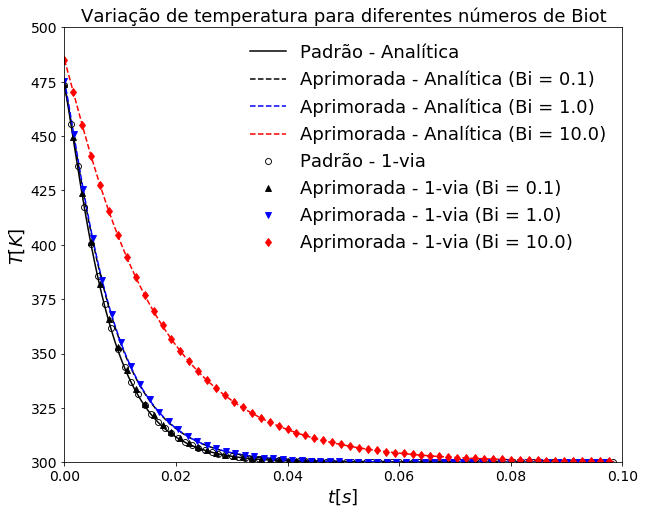

In [13]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way_padrao-t_one_way_padrao[0], T_p_RM_standard, linestyle = "-", color = "black", label = "Padrão - Analítica")
plt.plot(t_one_way_improved_Bi_01-t_one_way_improved_Bi_01[0], T_p_RM_improved_01, linestyle = "--", color = "black", 
         label = "Aprimorada - Analítica (Bi = {0:.1f})".format(Biot_RM_01[-1]))
plt.plot(t_one_way_improved_Bi_1-t_one_way_improved_Bi_1[0], T_p_RM_improved_1, linestyle = "--", color = "blue", 
         label = "Aprimorada - Analítica (Bi = {0:.1f})".format(Biot_RM_1[-1]))
plt.plot(t_one_way_improved_Bi_10-t_one_way_improved_Bi_10[0], T_p_RM_improved_10, linestyle = "--", color = "red", 
         label = "Aprimorada - Analítica (Bi = {0:.1f})".format(Biot_RM_10[-1]))

plt.plot(t_one_way_padrao-t_one_way_padrao[0], temp_one_way_padrao, linestyle = "None", marker = 'o', markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, 
           markerfacecolor = "none", label = "Padrão - 1-via")
plt.plot(t_one_way_improved_Bi_01-t_one_way_improved_Bi_01[0], temp_one_way_improved_Bi_01, linestyle = "None", 
         marker = '^', markeredgecolor = 'black',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "black", 
         label = "Aprimorada - 1-via (Bi = {0:.1f})".format(Biot_RM_01[-1]))
plt.plot(t_one_way_improved_Bi_1-t_one_way_improved_Bi_1[0], temp_one_way_improved_Bi_1, linestyle = "None", 
         marker = 'v', markeredgecolor = 'blue',  markeredgewidth = 0.9, markevery=17, markerfacecolor = "blue", 
         label = "Aprimorada - 1-via (Bi = {0:.1f})".format(Biot_RM_1[-1]))
plt.plot(t_one_way_improved_Bi_10-t_one_way_improved_Bi_10[0], temp_one_way_improved_Bi_10, linestyle = "None", 
         marker = 'd', markeredgecolor = 'red',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "red", 
         label = "Aprimorada - 1-via (Bi = {0:.1f})".format(Biot_RM_10[-1]))

#plt.title("Temperature Variation Over Time for Different $Nu$ Correlations", fontsize = 16)
plt.title("Variação de temperatura para diferentes números de Biot", fontsize = 18)
plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ylim(ymax = 500, ymin = 300)
plt.legend(loc = 1, frameon = False, fontsize = 18)
plt.savefig("temperatura_comparacao_padrao_aprimorada_1_via.png")
plt.show()



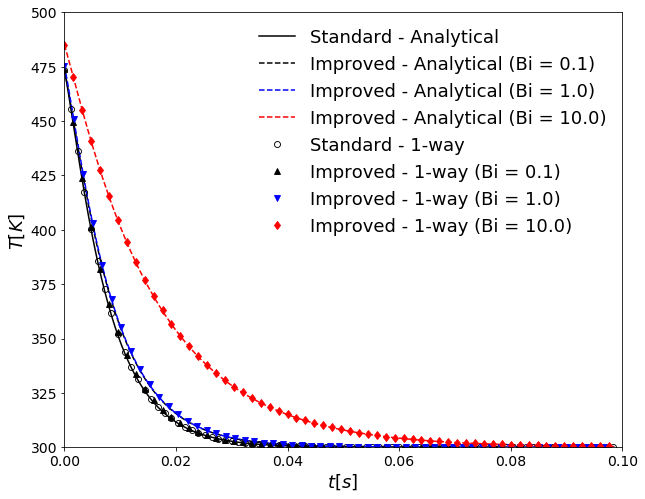

In [7]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way_padrao-t_one_way_padrao[0], T_p_RM_standard, linestyle = "-", color = "black", label = "Standard - Analytical")
plt.plot(t_one_way_improved_Bi_01-t_one_way_improved_Bi_01[0], T_p_RM_improved_01, linestyle = "--", color = "black", 
         label = "Improved - Analytical (Bi = {0:.1f})".format(Biot_RM_01[-1]))
plt.plot(t_one_way_improved_Bi_1-t_one_way_improved_Bi_1[0], T_p_RM_improved_1, linestyle = "--", color = "blue", 
         label = "Improved - Analytical (Bi = {0:.1f})".format(Biot_RM_1[-1]))
plt.plot(t_one_way_improved_Bi_10-t_one_way_improved_Bi_10[0], T_p_RM_improved_10, linestyle = "--", color = "red", 
         label = "Improved - Analytical (Bi = {0:.1f})".format(Biot_RM_10[-1]))

plt.plot(t_one_way_padrao-t_one_way_padrao[0], temp_one_way_padrao, linestyle = "None", marker = 'o', markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, 
           markerfacecolor = "none", label = "Standard - 1-way")
plt.plot(t_one_way_improved_Bi_01-t_one_way_improved_Bi_01[0], temp_one_way_improved_Bi_01, linestyle = "None", 
         marker = '^', markeredgecolor = 'black',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "black", 
         label = "Improved - 1-way (Bi = {0:.1f})".format(Biot_RM_01[-1]))
plt.plot(t_one_way_improved_Bi_1-t_one_way_improved_Bi_1[0], temp_one_way_improved_Bi_1, linestyle = "None", 
         marker = 'v', markeredgecolor = 'blue',  markeredgewidth = 0.9, markevery=17, markerfacecolor = "blue", 
         label = "Improved - 1-way (Bi = {0:.1f})".format(Biot_RM_1[-1]))
plt.plot(t_one_way_improved_Bi_10-t_one_way_improved_Bi_10[0], temp_one_way_improved_Bi_10, linestyle = "None", 
         marker = 'd', markeredgecolor = 'red',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "red", 
         label = "Improved - 1-way (Bi = {0:.1f})".format(Biot_RM_10[-1]))

#plt.title("Temperature Variation for Different Biot numbers", fontsize = 16)
#plt.title("Variação de temperatura para diferentes números de Biot", fontsize = 18)
plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ylim(ymax = 500, ymin = 300)
plt.legend(loc = 1, frameon = False, fontsize = 18)
plt.savefig("temperatura_comparacao_padrao_aprimorada_1_via_english.png")
plt.show()

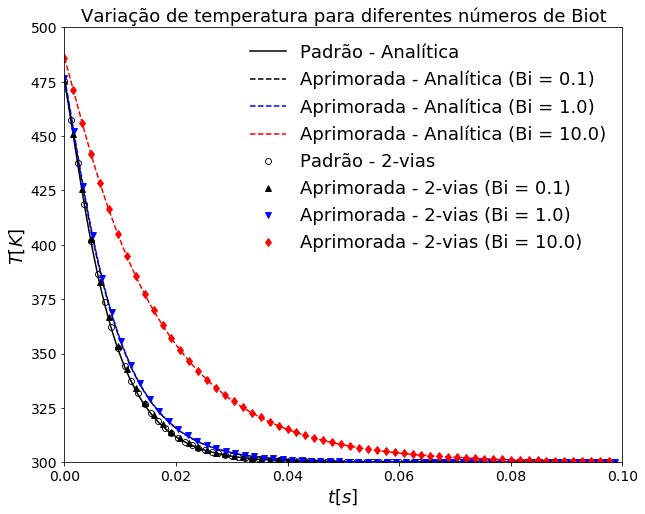

In [8]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_two_way_padrao-t_two_way_padrao[0], T_p_RM_standard_2way, linestyle = "-", color = "black", 
         label = "Padrão - Analítica")
plt.plot(t_two_way_improved_Bi_01-t_two_way_improved_Bi_01[0], T_p_RM_improved_01_2way, 
         linestyle = "--", color = "black", label = "Aprimorada - Analítica (Bi = {0:.1f})".format(Biot_RM_01_2way[-1]))
plt.plot(t_two_way_improved_Bi_1-t_two_way_improved_Bi_1[0], T_p_RM_improved_1_2way, 
         linestyle = "--", color = "blue", label = "Aprimorada - Analítica (Bi = {0:.1f})".format(Biot_RM_1_2way[-1]))
plt.plot(t_two_way_improved_Bi_10-t_two_way_improved_Bi_10[0], T_p_RM_improved_10_2way, 
         linestyle = "--", color = "red", label = "Aprimorada - Analítica (Bi = {0:.1f})".format(Biot_RM_10_2way[-1]))

plt.plot(t_two_way_padrao-t_two_way_padrao[0], temp_two_way_padrao, linestyle = "None", marker = 'o', markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, 
           markerfacecolor = "none", label = "Padrão - 2-vias")
plt.plot(t_two_way_improved_Bi_01-t_two_way_improved_Bi_01[0], temp_two_way_improved_Bi_01, linestyle = "None", 
         marker = '^', markeredgecolor = 'black',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "black", 
         label = "Aprimorada - 2-vias (Bi = {0:.1f})".format(Biot_RM_01_2way[-1]))
plt.plot(t_two_way_improved_Bi_1-t_two_way_improved_Bi_1[0], temp_two_way_improved_Bi_1, linestyle = "None", 
         marker = 'v', markeredgecolor = 'blue',  markeredgewidth = 0.9, markevery=17, markerfacecolor = "blue", 
         label = "Aprimorada - 2-vias (Bi = {0:.1f})".format(Biot_RM_1_2way[-1]))
plt.plot(t_two_way_improved_Bi_10-t_two_way_improved_Bi_10[0], temp_two_way_improved_Bi_10, linestyle = "None", 
         marker = 'd', markeredgecolor = 'red',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "red", 
         label = "Aprimorada - 2-vias (Bi = {0:.1f})".format(Biot_RM_10_2way[-1]))

#plt.title("Temperature Variation Over Time for Different $Nu$ Correlations", fontsize = 16)
plt.title("Variação de temperatura para diferentes números de Biot", fontsize = 18)
plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ylim(ymax = 500, ymin = 300)
plt.legend(loc = 1, frameon = False, fontsize = 18)
plt.savefig("temperatura_comparacao_padrao_aprimorada_duas_vias.png")
plt.show()

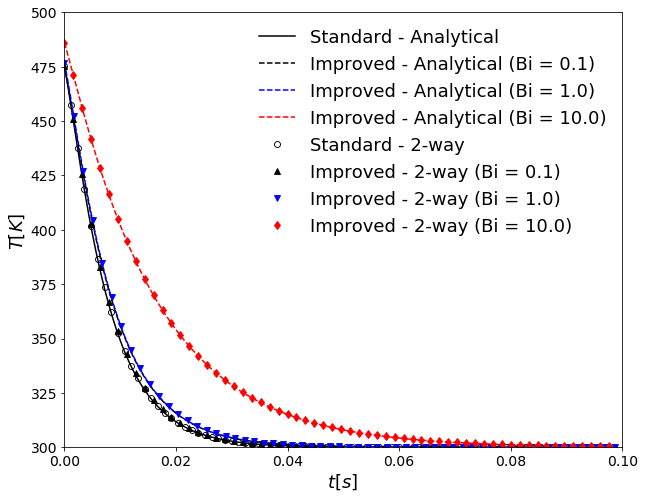

In [9]:
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_two_way_padrao-t_two_way_padrao[0], T_p_RM_standard_2way, linestyle = "-", color = "black", 
         label = "Standard - Analytical")
plt.plot(t_two_way_improved_Bi_01-t_two_way_improved_Bi_01[0], T_p_RM_improved_01_2way, 
         linestyle = "--", color = "black", label = "Improved - Analytical (Bi = {0:.1f})".format(Biot_RM_01_2way[-1]))
plt.plot(t_two_way_improved_Bi_1-t_two_way_improved_Bi_1[0], T_p_RM_improved_1_2way, 
         linestyle = "--", color = "blue", label = "Improved - Analytical (Bi = {0:.1f})".format(Biot_RM_1_2way[-1]))
plt.plot(t_two_way_improved_Bi_10-t_two_way_improved_Bi_10[0], T_p_RM_improved_10_2way, 
         linestyle = "--", color = "red", label = "Improved - Analytical (Bi = {0:.1f})".format(Biot_RM_10_2way[-1]))

plt.plot(t_two_way_padrao-t_two_way_padrao[0], temp_two_way_padrao, linestyle = "None", marker = 'o', markeredgecolor = "black",  markeredgewidth = 0.9, markevery=12, 
           markerfacecolor = "none", label = "Standard - 2-way")
plt.plot(t_two_way_improved_Bi_01-t_two_way_improved_Bi_01[0], temp_two_way_improved_Bi_01, linestyle = "None", 
         marker = '^', markeredgecolor = 'black',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "black", 
         label = "Improved - 2-way (Bi = {0:.1f})".format(Biot_RM_01_2way[-1]))
plt.plot(t_two_way_improved_Bi_1-t_two_way_improved_Bi_1[0], temp_two_way_improved_Bi_1, linestyle = "None", 
         marker = 'v', markeredgecolor = 'blue',  markeredgewidth = 0.9, markevery=17, markerfacecolor = "blue", 
         label = "Improved - 2-way (Bi = {0:.1f})".format(Biot_RM_1_2way[-1]))
plt.plot(t_two_way_improved_Bi_10-t_two_way_improved_Bi_10[0], temp_two_way_improved_Bi_10, linestyle = "None", 
         marker = 'd', markeredgecolor = 'red',  markeredgewidth = 0.9, markevery=16, markerfacecolor = "red", 
         label = "Improved - 2-way (Bi = {0:.1f})".format(Biot_RM_10_2way[-1]))

#plt.title("Temperature Variation Over Time for Different $Nu$ Correlations", fontsize = 16)
#plt.title("Variação de temperatura para diferentes números de Biot", fontsize = 18)
plt.xlabel("$t [s]$ ", fontsize = 18)
plt.ylabel("$T [K]$ ", fontsize = 18)
plt.xlim(xmin = 0, xmax = 0.1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ylim(ymax = 500, ymin = 300)
plt.legend(loc = 1, frameon = False, fontsize = 18)
plt.savefig("temperatura_comparacao_padrao_aprimorada_duas_vias_english.png")
plt.show()

In [10]:
error_RM = np.absolute(100*(T_p_RM - temp_one_way_RM)/T_p_RM)
error_W = np.absolute(100*(T_p_W - temp_one_way_W)/T_p_W)
#error_vel_1_way = np.absolute(100*(limited_vel_anal_one_way - limited_vel_one_way)/limited_vel_anal_one_way)
#print(error_RM)

plt.plot(t_one_way_RM-t_one_way_RM[0],error_RM, linewidth = 2, color = "blue", linestyle= '-', label = "Ranz & Marshall")
plt.plot(t_one_way_W-t_one_way_W[0],error_W, linewidth = 2, color = "red", linestyle= '-', label = "Whitaker")
plt.xlabel('Time (s)',  fontsize = 18)
plt.ylabel('Error (%)',  fontsize = 18)
plt.title("Error for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='upper right', frameon = False)
#plt.xlim(xmax = time_two_way.max(), xmin = 0)
plt.xlim(xmax = 0.08, xmin = 0)
plt.ylim(ymax = 0.1, ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('error_cooling_particle_water.png')
plt.show()

plt.plot(t_one_way_RM-t_one_way_RM[0],error_RM, linewidth = 2, color = "black", linestyle= '-', label = "Ranz & Marshall")
plt.plot(t_one_way_W-t_one_way_W[0],error_W, linewidth = 2, color = "black", linestyle= '--', label = "Whitaker")
plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Erro (%)',  fontsize = 18)
#plt.title("Error for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='upper right', frameon = False)
#plt.xlim(xmax = time_two_way.max(), xmin = 0)
plt.xlim(xmax = 0.08, xmin = 0)
plt.ylim(ymax = 0.1, ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('erro_cooling_particle.png')
plt.show()



NameError: name 'T_p_RM' is not defined